In [1]:
import numpy as np
import pandas as pd
import json
import tensorflow as tf
import gensim
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from gensim.models import Word2Vec, KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPool1D, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
from gensim.models import KeyedVectors
from nltk.tokenize import sent_tokenize, word_tokenize
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import gensim.downloader as api
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

In [2]:
# import nltk
# nltk.download('punkt')

# from nltk import word_tokenize,sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Unzip the Word2Vec

In [ ]:
# import gzip

# try:
#     with gzip.open('GoogleNews-vectors-negative300.bin.gz', 'rb') as f_in, open('SGoogleNews-vectors-negative300.bin', 'wb') as f_out:
#         f_out.write(f_in.read())
#         print("Decompression complete! The uncompressed file is now available at /content/GoogleNews-vectors-negative300.bin")
# except FileNotFoundError:
#     print("Error: File not found at the specified path. Please ensure the file exists and the path is correct.")
# except OSError as e:
#     print(f"Error: {e}")


# Load word2vec model

In [ ]:
# word_vectors = KeyedVectors.load_word2vec_format('PGoogleNews-vectors-negative300.bin', binary=True)

In [5]:
word_vectors = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


# Define the LSTM-based model

In [6]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, word_embeddings):
        super(LSTMTagger, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.linear(lstm_out)
        return tag_space

# Data Preprocessing

##### Load Data, Prepare Vocab and Padded Sequences.

In [7]:
class ReviewDataset(Dataset):
    def __init__(self, data_path, word_vectors, max_seq_length):
        self.data_path = data_path
        self.word_vectors = word_vectors
        self.max_seq_length = max_seq_length
        self.data = self.load_data()
        self.word_to_idx, self.label_to_idx = self.prepare_vocab()
        self.X, self.y = self.prepare_data()

    def load_data(self):
        with open(self.data_path, 'r') as f:
            data = json.load(f)
        return data

    def prepare_vocab(self):
        word_to_idx = {word: idx + 1 for idx, word in enumerate(self.word_vectors.index_to_key)}
        label_to_idx = {"B": 0, "I": 1, "O": 2}
        return word_to_idx, label_to_idx

    def prepare_data(self):
        X, y = [], []
        for sample in self.data.values():
            text = sample['text'].split()
            labels = sample['labels']
            text_indices = [self.word_to_idx.get(word, 0) for word in text]
            X.append(torch.tensor(text_indices))
            y.append(torch.tensor([self.label_to_idx[label] for label in labels]))
        X_padded = pad_sequence(X, batch_first=True, padding_value=0)
        y_padded = pad_sequence(y, batch_first=True, padding_value=0)
        return X_padded, y_padded

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Training Model Function

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_f1s = []
    val_f1s = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        train_all_preds = []
        train_all_labels = []
        for text, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(text)
            loss = criterion(outputs.view(-1, tagset_size), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 2)
            train_all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
            train_all_labels.extend(labels.view(-1).cpu().numpy().tolist())

        val_loss = 0
        val_all_preds = []
        val_all_labels = []
        with torch.no_grad():
            model.eval()
            for text, labels in val_loader:
                outputs = model(text)
                loss = criterion(outputs.view(-1, tagset_size), labels.view(-1))
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 2)
                val_all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
                val_all_labels.extend(labels.view(-1).cpu().numpy().tolist())

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_f1 = f1_score(train_all_labels, train_all_preds, average='macro')
        val_f1 = f1_score(val_all_labels, val_all_preds, average='macro')
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Macro-F1: {train_f1:.4f}, Validation Macro-F1: {val_f1:.4f}")

    return train_losses, val_losses, train_f1s, val_f1s


# Main

In [9]:
max_seq_length = 100

# Create data loaders
train_dataset = ReviewDataset('ATE_train.json', word_vectors, max_seq_length)
val_dataset = ReviewDataset('ATE_val.json', word_vectors, max_seq_length)
test_dataset = ReviewDataset('ATE_test.json', word_vectors, max_seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define model parameters
embedding_dim = word_vectors.vector_size
hidden_dim = 128
vocab_size = len(word_vectors.index_to_key)
tagset_size = 3

# Train the model
model = LSTMTagger(embedding_dim, hidden_dim, vocab_size, tagset_size, torch.FloatTensor(word_vectors.vectors))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, train_f1s, val_f1s = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10, Training Loss: 18.5904, Validation Loss: 1.3180, Training Macro-F1: 0.5196, Validation Macro-F1: 0.6153
Epoch 2/10, Training Loss: 4.5229, Validation Loss: 0.8862, Training Macro-F1: 0.6262, Validation Macro-F1: 0.6324
Epoch 3/10, Training Loss: 3.7920, Validation Loss: 0.8208, Training Macro-F1: 0.6333, Validation Macro-F1: 0.6346
Epoch 4/10, Training Loss: 3.5961, Validation Loss: 0.7863, Training Macro-F1: 0.6351, Validation Macro-F1: 0.6359
Epoch 5/10, Training Loss: 3.4539, Validation Loss: 0.7573, Training Macro-F1: 0.6360, Validation Macro-F1: 0.6364
Epoch 6/10, Training Loss: 3.2809, Validation Loss: 0.7292, Training Macro-F1: 0.6365, Validation Macro-F1: 0.6375
Epoch 7/10, Training Loss: 3.1274, Validation Loss: 0.7000, Training Macro-F1: 0.6372, Validation Macro-F1: 0.6380
Epoch 8/10, Training Loss: 3.0351, Validation Loss: 0.6713, Training Macro-F1: 0.6385, Validation Macro-F1: 0.6392
Epoch 9/10, Training Loss: 2.8717, Validation Loss: 0.6450, Training Macro-F1: 

# Generate plots

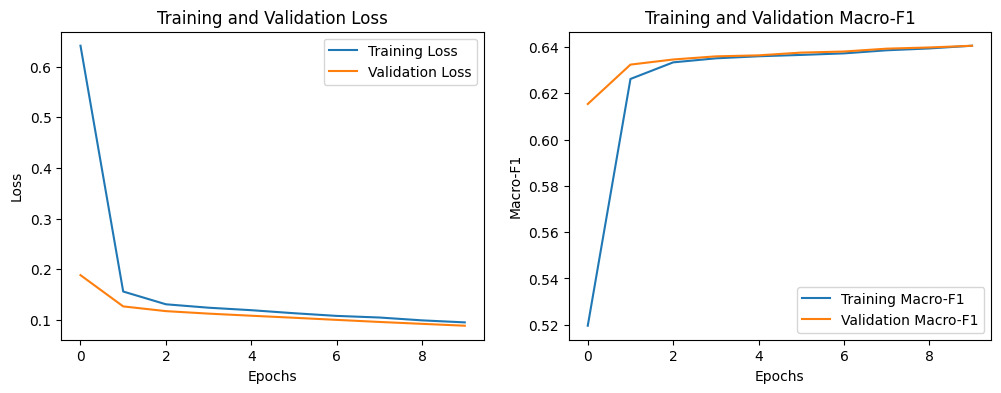

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_f1s, label='Training Macro-F1')
plt.plot(val_f1s, label='Validation Macro-F1')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1')
plt.legend()
plt.title('Training and Validation Macro-F1')
plt.show()

# Save the model for future inference

In [11]:
torch.save(model.state_dict(), 't2_model2_word2vec.pt')

~fin~